In [22]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
import proplot

/home/agalicina/anaconda3/envs/test/lib/python3.8/site-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


## Prepare the genome

In [ ]:
# Activate bwa and minimap2 plugins for genomepy:
! genomepy plugins enable bwa
! genomepy plugins enable minimap2

In [ ]:
# Install hg38 genome by genomepy:
! genomepy install hg38

In [5]:
# location of the genome:
! ls ~/.local/share/genomes/hg38/

hg38.blacklist.bed.gz  hg38.fa.fai    hg38.gaps.bed  README.txt
hg38.fa		       hg38.fa.sizes  index


In [6]:
# Copy it to the local folder to simplify the code
! cp -r ~/.local/share/genomes/hg38 ./

^C


In [7]:
# Digest the genome:
! cooler digest ./hg38/hg38.fa.sizes ./hg38/hg38.fa DpnII > ./hg38/hg38_DpnII.bed

## Long-read Arima example

Comparison os parse and parse2 outputs on 150 bp reads.

Example from [human cell line](https://www.ncbi.nlm.nih.gov/sra/SRX10230900[accn]): SRR13849430

In [1]:
# Download test data
! fastq-dump SRR13849430 --gzip --split-spot --split-3 --minSpotId 0 --maxSpotId 1000000

Read 1000000 spots for SRR13849430
Written 1000000 spots for SRR13849430


In [3]:
# Map test data:
! bwa mem -t 5 -SP ~/.local/share/genomes/hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz > test.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 333334 sequences (50000100 bp)...
[M::process] read 333334 sequences (50000100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (3287, 41601, 3132, 3247)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1474, 3107, 5770)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14362)
[M::mem_pestat] mean and std.dev: (3761.23, 2688.41)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 18658)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (223, 289, 356)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 622)
[M::mem_pestat] mean and std.dev: (277.40, 91.07)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 755)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 

[M::mem_process_seqs] Processed 333330 reads in 326.313 CPU sec, 68.738 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 5 -SP /home/agalicina/.local/share/genomes//hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz
[main] Real time: 528.991 sec; CPU: 2212.054 sec


### Run regular parse

In [123]:
%%bash
pairtools parse -o test_arima_parse.pairs.gz -c ./hg38/hg38.fa.sizes \
  --drop-sam --drop-seq --output-stats test_arima_parse.stats \
  --assembly hg38 --no-flip \
  --add-columns pos5,pos3 \
  --walks-policy mask \
  test.bam 

In [124]:
%%bash
gzip -dc test_arima_parse.pairs.gz | grep -v "#" | head -n 10 | cat
# Note that there are now pos5 and pos3 columns:

SRR13849430.1	chr12	78795816	!	0	-	-	UN	78795816	0	78795720	0
SRR13849430.2	!	0	!	0	-	-	WW	0	0	0	0
SRR13849430.3	chr2	72005391	!	0	+	-	UN	72005391	0	72005521	0
SRR13849430.4	chr2	20530788	!	0	+	-	UN	20530788	0	20530937	0
SRR13849430.5	!	0	!	0	-	-	WW	0	0	0	0
SRR13849430.6	chr3	857974	!	0	+	-	UN	857974	0	858099	0
SRR13849430.7	!	0	!	0	-	-	WW	0	0	0	0
SRR13849430.8	chr19	40057590	!	0	-	-	RN	40057590	0	40057465	0
SRR13849430.9	chr6	111954600	!	0	-	-	RN	111954600	0	111954451	0
SRR13849430.10	!	0	!	0	-	-	WW	0	0	0	0


In [138]:
# Read the stats of regular parse:
stats_parse = pd.read_table('./test_arima_parse.stats', header=None)
stats_parse.columns = ['stat', 'count']
stats_parse.set_index('stat', inplace=True)

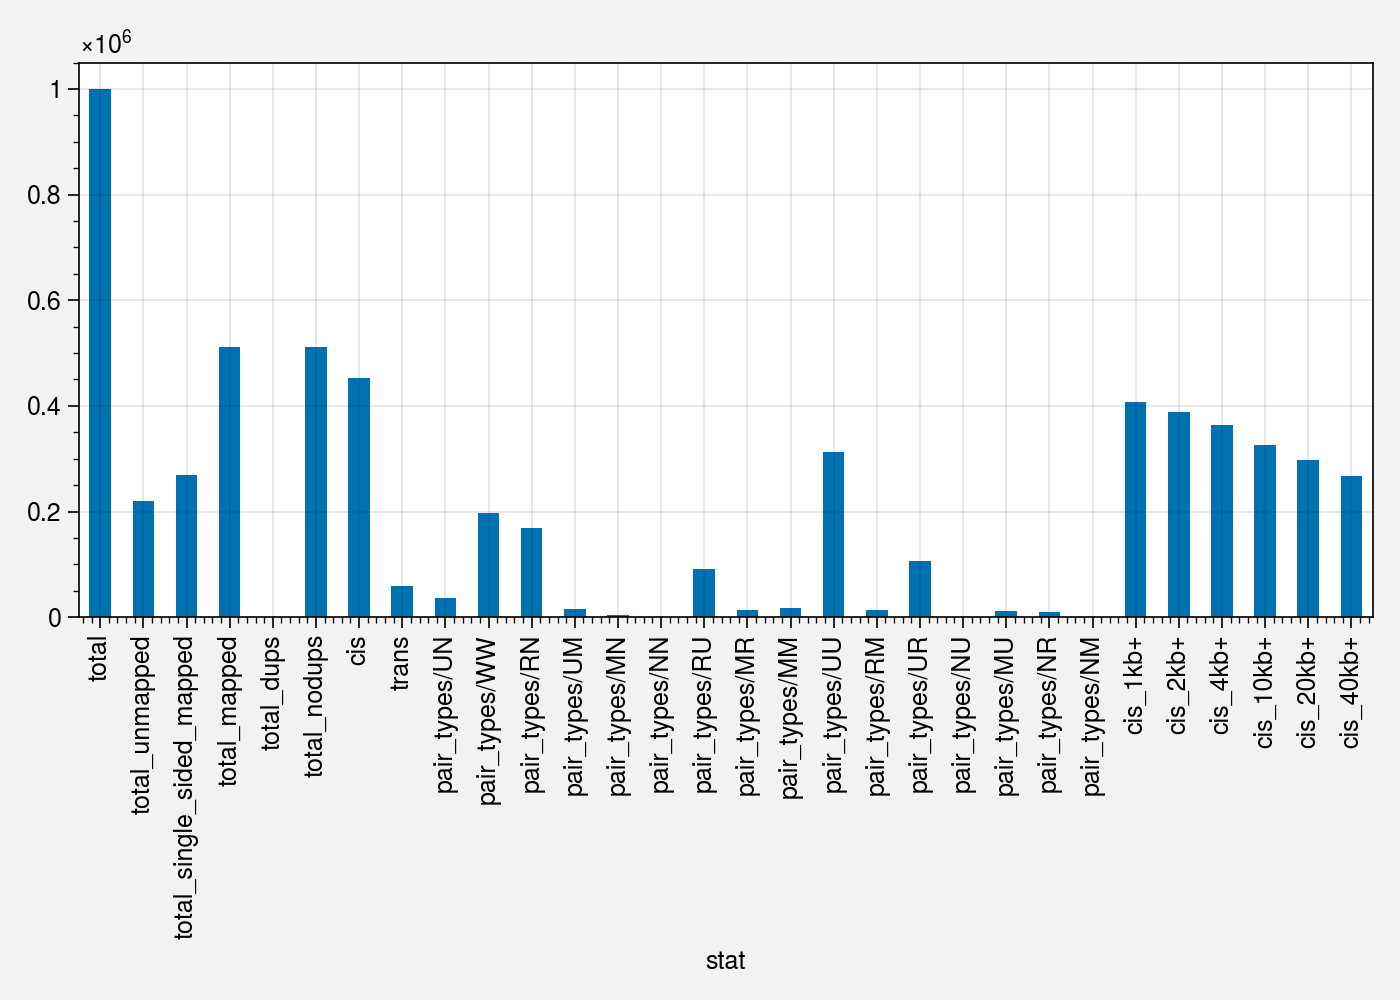

In [80]:
columns = [x for x in stats_parse.index if not 'freq' in x]

plt.figure(figsize=[7, 5])
stats_parse.loc[columns, 'count'].plot(kind='bar')
plt.tight_layout()

### Run parse2

In [196]:
%%bash
# Call for help:
pairtools parse2 -h

Usage: pairtools parse2 [OPTIONS] [SAM_PATH]

  Find ligation junctions in .sam, make .pairs. SAM_PATH : an input
  .sam/.bam file with paired-end sequence alignments of Hi-C molecules. If
  the path ends with .bam, the input is decompressed from bam with samtools.
  By default, the input is read from stdin.

Options:
  -c, --chroms-path TEXT          Chromosome order used to flip
                                  interchromosomal mates: path to a
                                  chromosomes file (e.g. UCSC chrom.sizes or
                                  similar) whose first column lists scaffold
                                  names. Any scaffolds not listed will be
                                  ordered lexicographically following the
                                  names provided.  [required]

  --assembly TEXT                 Name of genome assembly (e.g. hg19, mm10) to
                                  store in the pairs header.

  --min-mapq INTEGER              The mini

In [127]:
%%bash
# Report pairs as if each one was sequenced independetly (coord system "pair")
pairtools parse2 -o test_arima_parse2.pairs.gz -c ./hg38/hg38.fa.sizes \
  --drop-sam --drop-seq --output-stats test_arima_parse2.stats \
  --assembly hg38 --no-flip \
  --add-columns pos5,pos3 \
  --add-junction-index \
  --coordinate-system pair \
  test.bam

In [153]:
stats_parse2 = pd.read_table('./test_arima_parse2.stats', header=None)
stats_parse2.columns = ['stat', 'count']
stats_parse2.set_index('stat', inplace=True)

In [154]:
stats_parse.loc[:, 'mode'] = 'arima_parse'
stats_parse2.loc[:, 'mode'] = 'arima_parse2'
stats_all = pd.concat([stats_parse, stats_parse2])

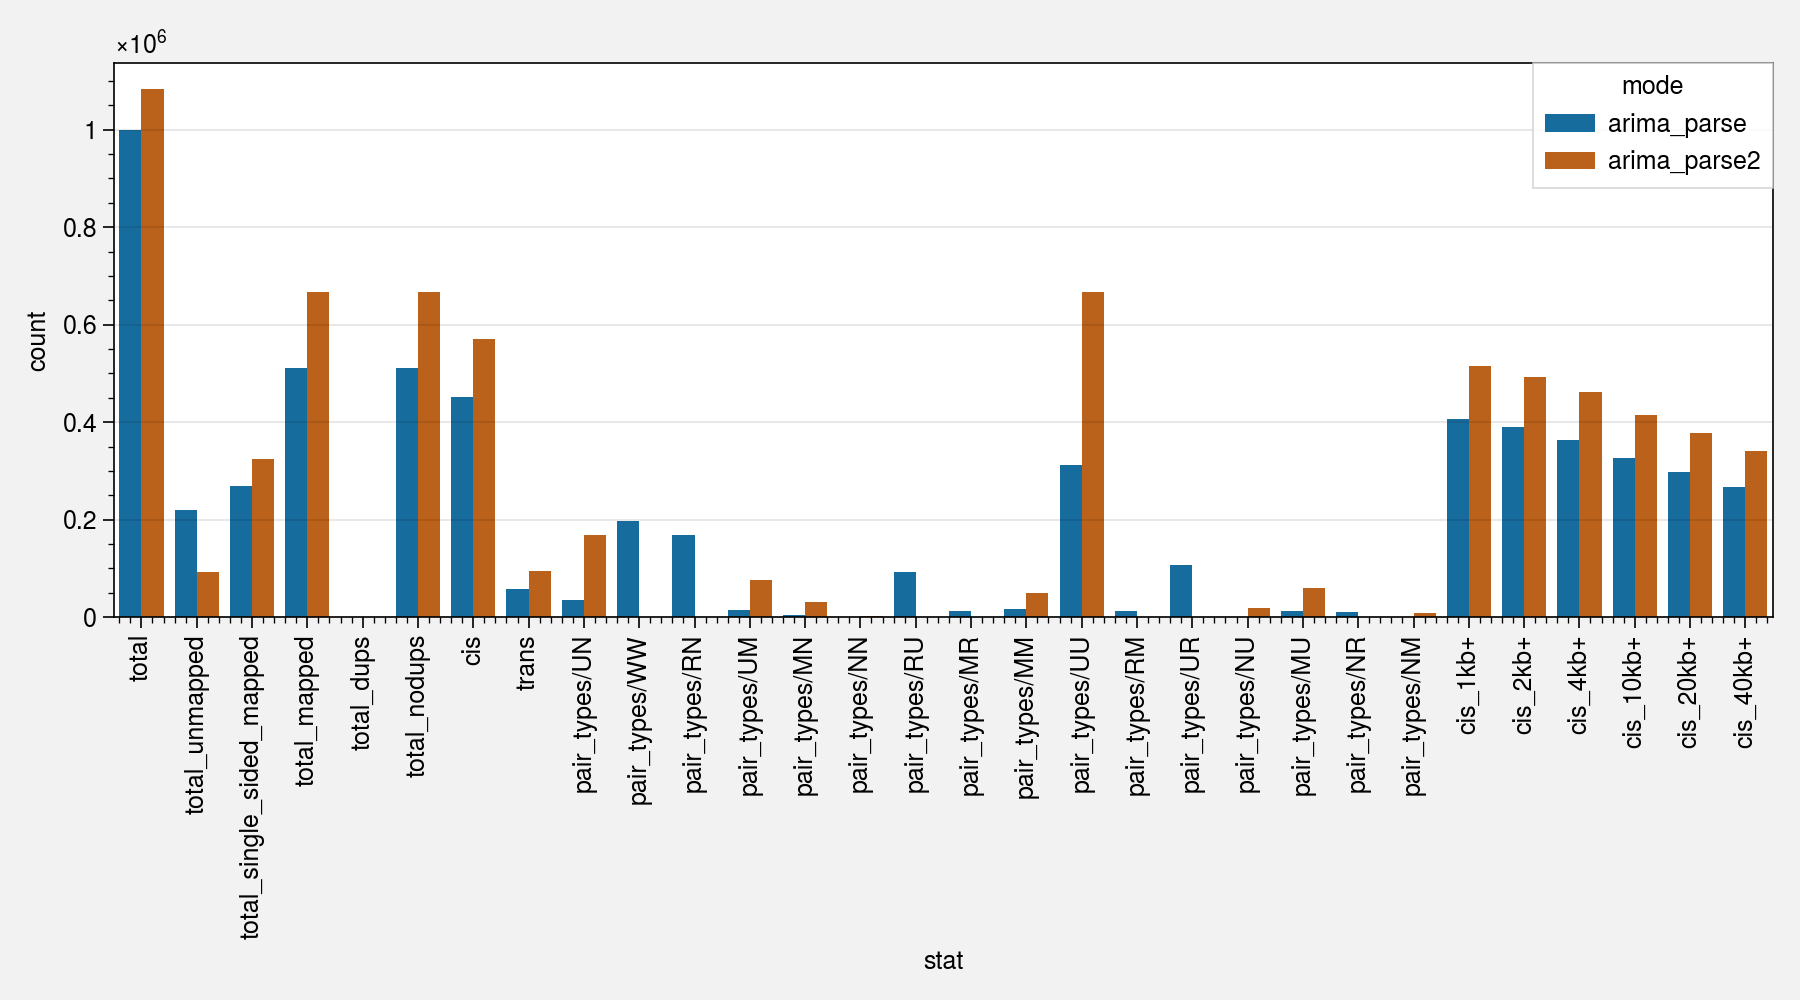

In [155]:
columns = [x for x in stats_parse.index if not 'freq' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='count', x='stat', hue='mode')
plt.xticks(rotation=90)

plt.tight_layout()
# Note the artificial increase in the total number of pairs:

Check P(s) for two regimes:

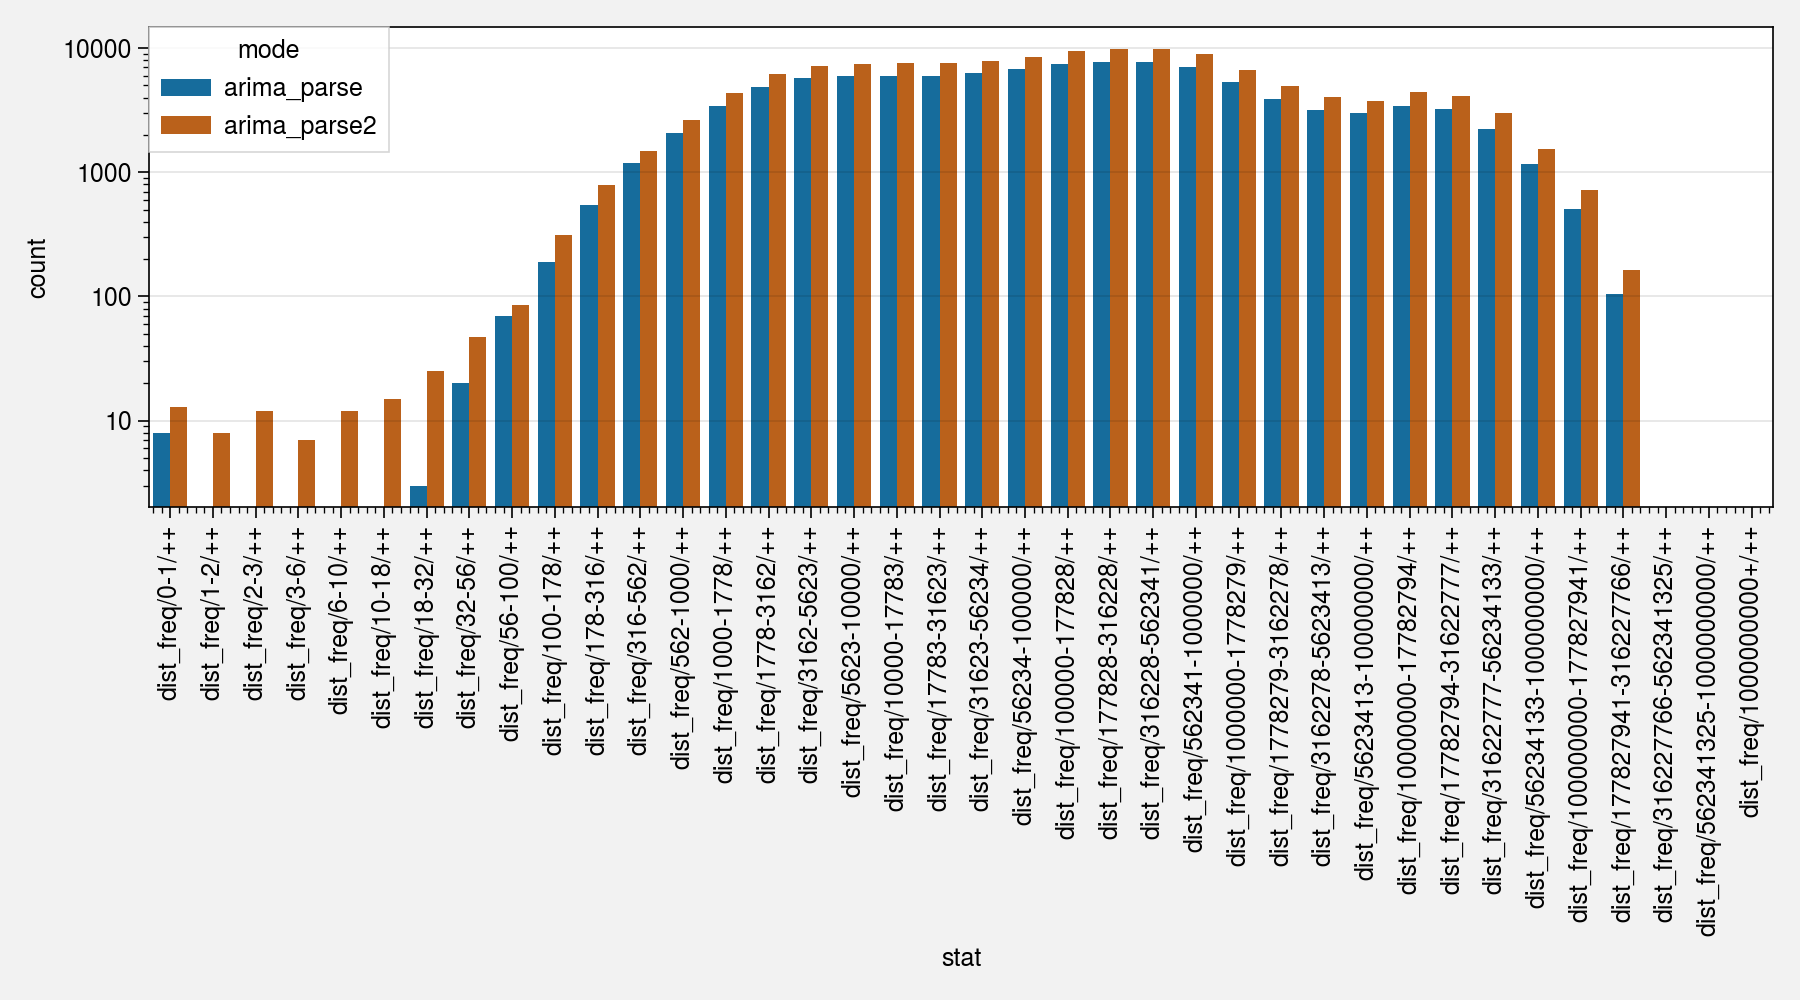

In [156]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '++' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='count', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.tight_layout()

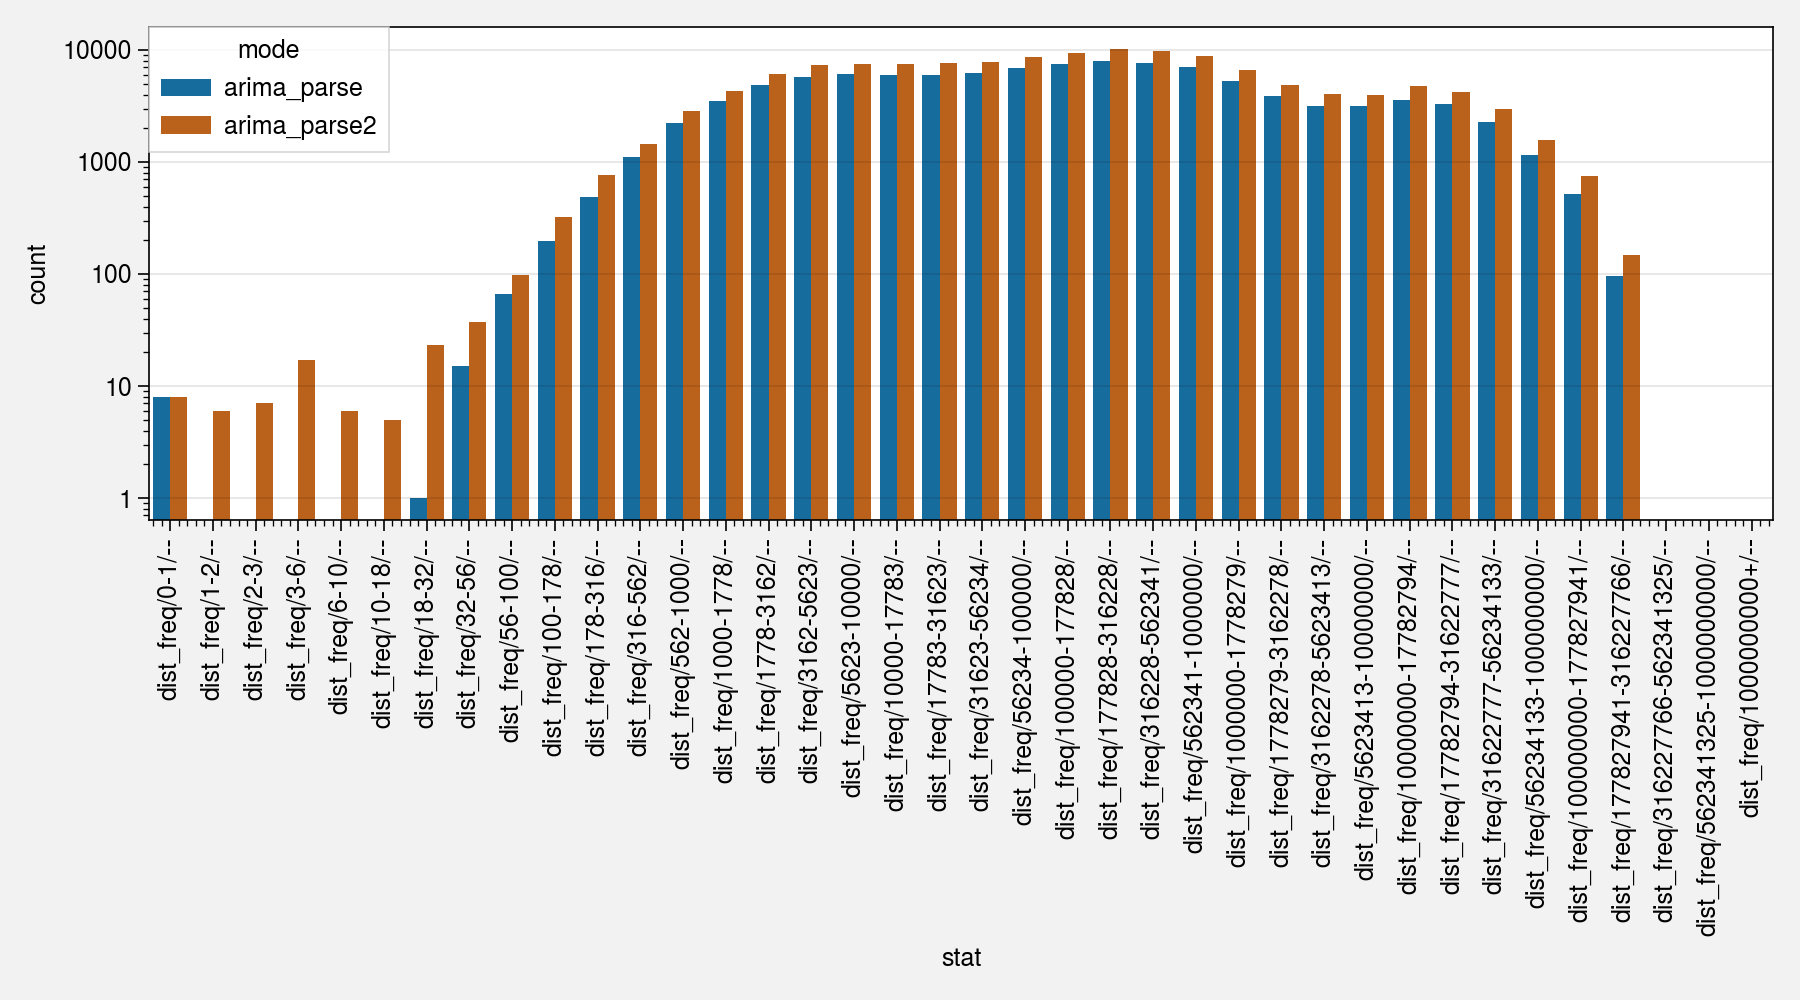

In [157]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '--' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='count', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.tight_layout()

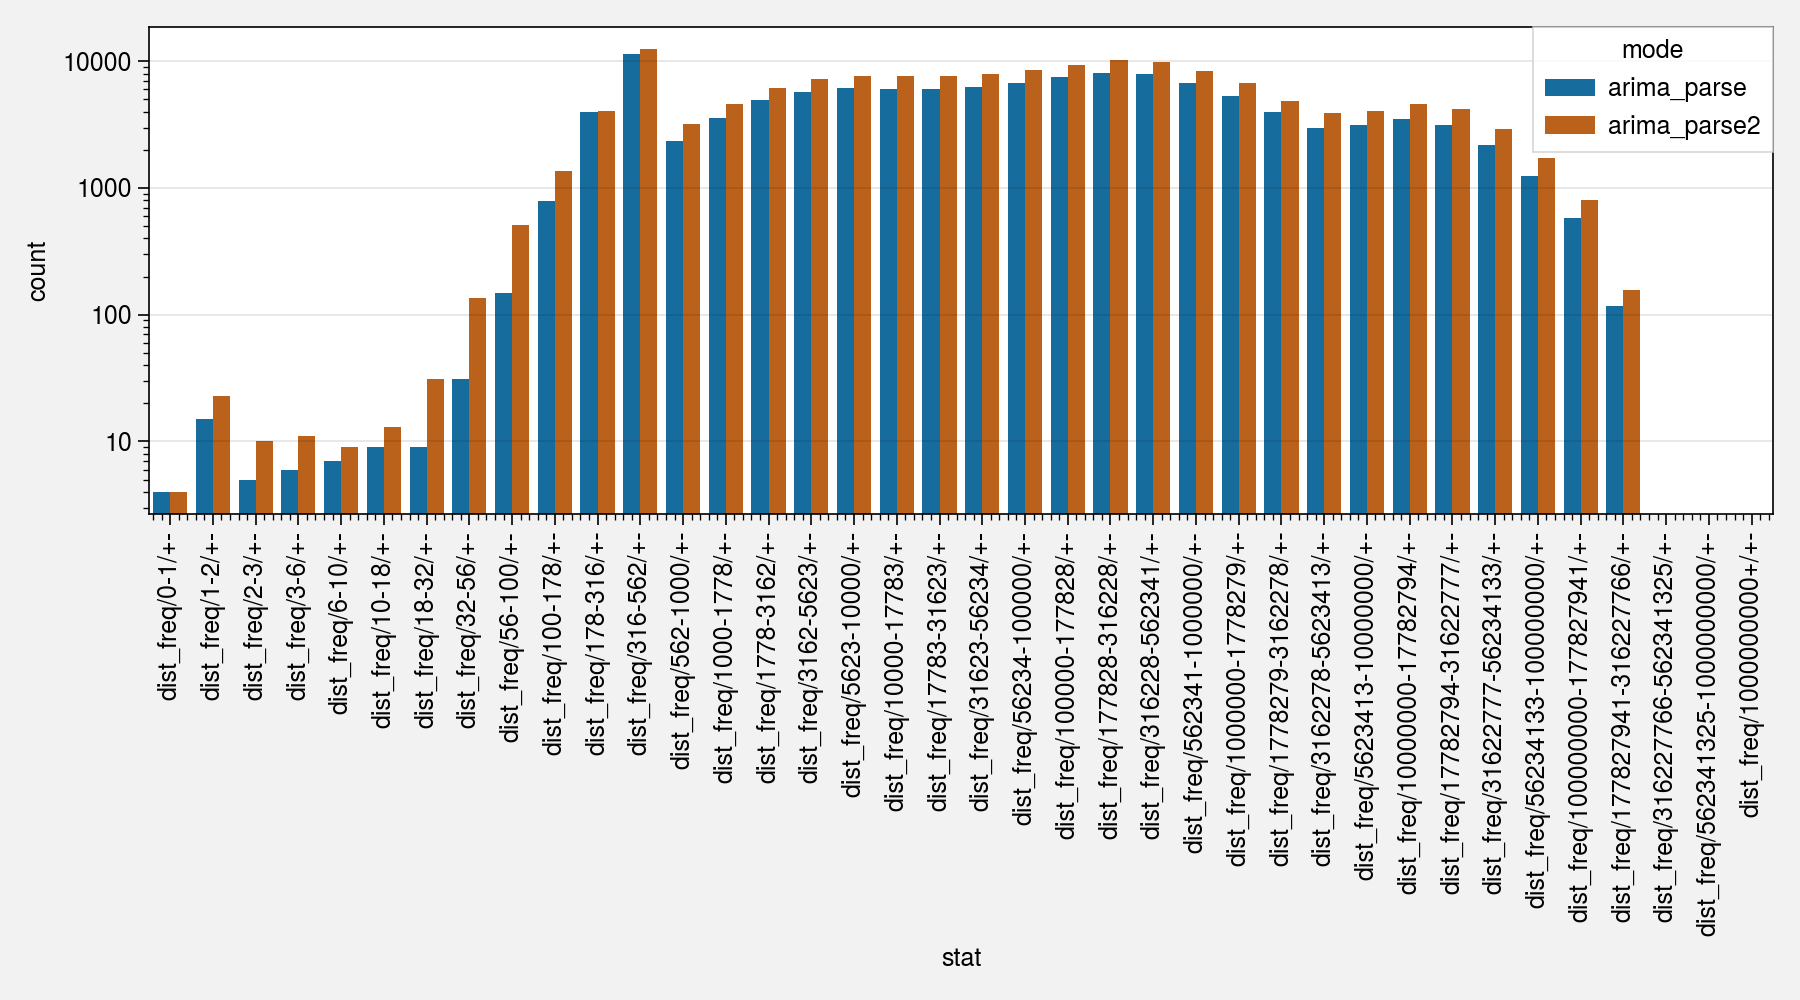

In [158]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '+-' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='count', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.tight_layout()

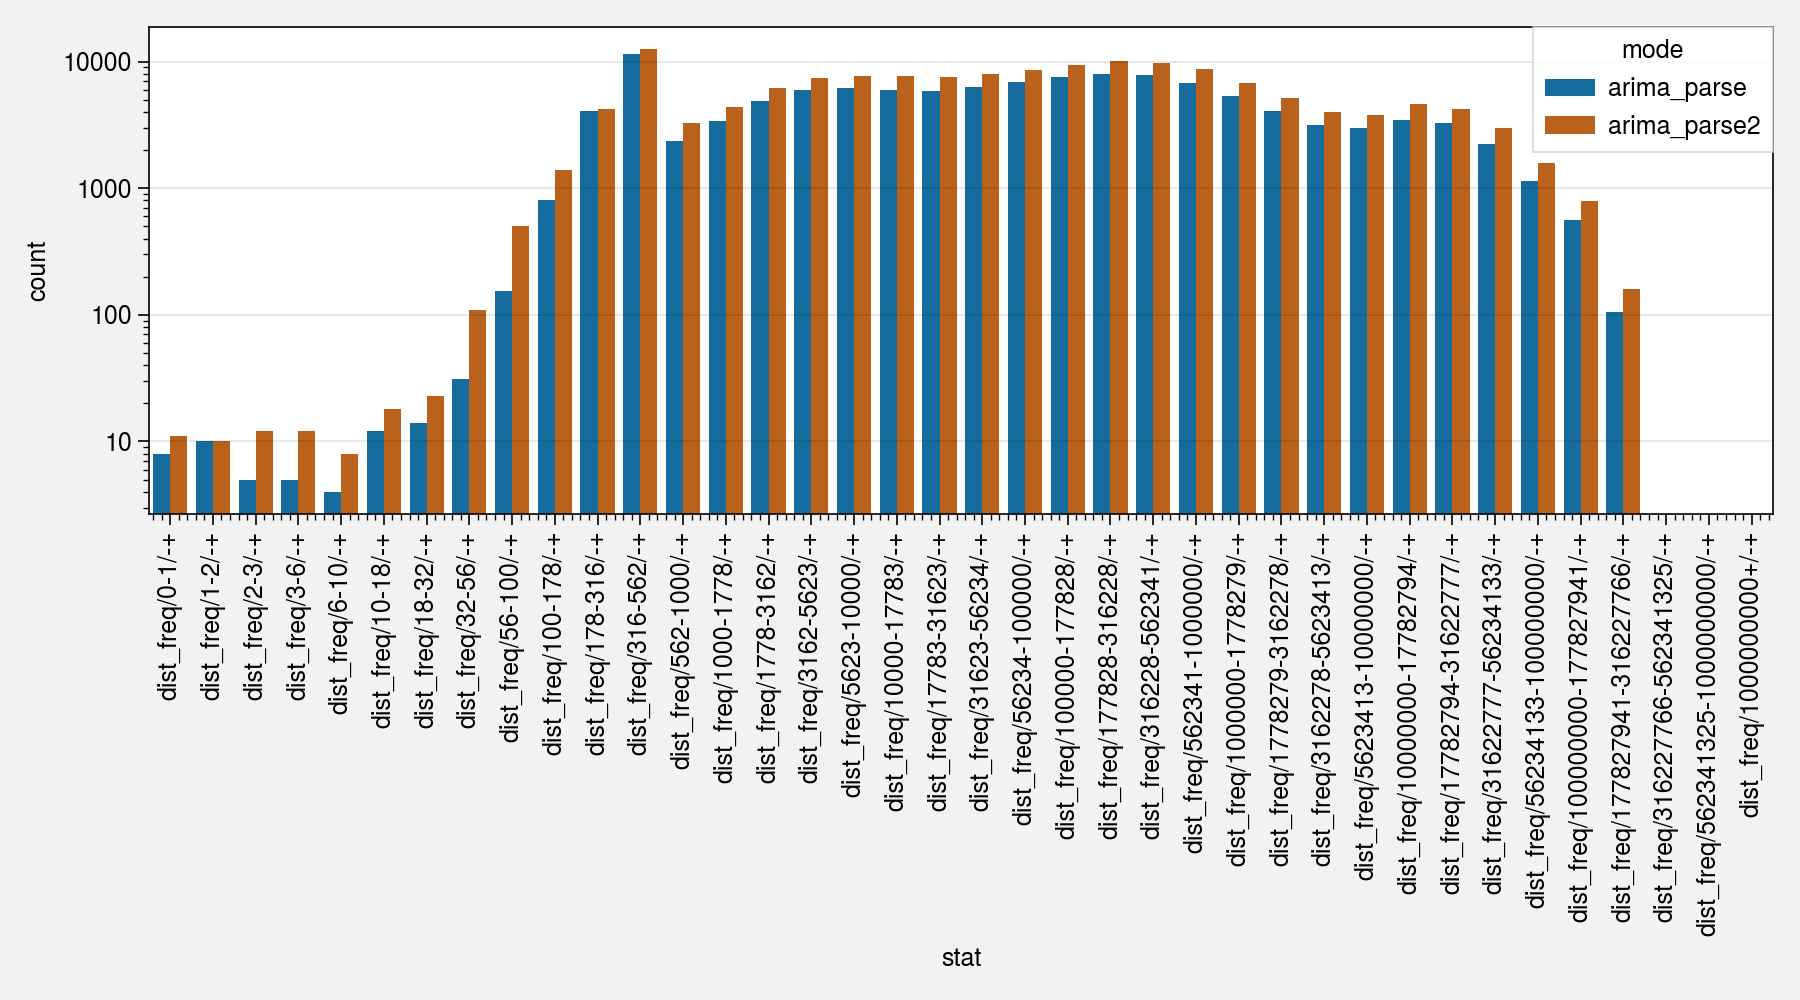

In [159]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '-+' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='count', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.tight_layout()

### ~~Restriction at the ends of alignments:~~

tests to be implemented, for now only checks the restriction

In [128]:
%%bash
# Select only UU and RU reads for parse and restrict:
pairtools select '(pair_type == "UU") or (pair_type == "UR") or (pair_type == "RU")' \
  -o test_arima_parse.UU.pairs.gz test_arima_parse.pairs.gz
  
pairtools restrict -f ./hg38/hg38_DpnII.bed -o test_arima_parse.UU.restricted.pairs.gz test_arima_parse.UU.pairs.gz

/home/agalicina/soft/pairtools2/pairtools/pairtools/pairtools_restrict.py:63: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  rfrags = np.genfromtxt(


In [129]:
%%bash
# Select only UU reads for parse2 and restrict:
pairtools select '(pair_type == "UU")' \
  -o test_arima_parse2.UU.pairs.gz test_arima_parse2.pairs.gz
  
pairtools restrict -f ./hg38/hg38_DpnII.bed -o test_arima_parse2.UU.restricted.pairs.gz test_arima_parse2.UU.pairs.gz

/home/agalicina/soft/pairtools2/pairtools/pairtools/pairtools_restrict.py:63: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  rfrags = np.genfromtxt(


## Nanopore single-end example: MC-3C

Single-end Nanopore data from MC-3C [GSE146945](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146945):

In [4]:
%%bash
# Download test data
! fastq-dump SRR11304457 --minSpotId 0 --maxSpotId 1000000

Read 21359 spots for SRR11304457
Written 21359 spots for SRR11304457


In [135]:
%%bash
# Align with minimap2: 
minimap2 -a ./hg38/index/minimap2/hg38.mmi SRR11304457.fastq > mc3c-test.sam

[M::main::9.122*0.99] loaded/built the index for 24 target sequence(s)
[M::mm_mapopt_update::10.979*1.00] mid_occ = 704
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 24
[M::mm_idx_stat::12.130*1.00] distinct minimizers: 100128525 (38.78% are singletons); average occurrences: 5.526; average spacing: 5.581; total length: 3088269832
[M::worker_pipeline::94.133*2.71] mapped 21359 sequences
[M::main] Version: 2.18-r1015
[M::main] CMD: minimap2 -a ./hg38/index/minimap2/hg38.mmi SRR11304457.fastq
[M::main] Real time: 94.654 sec; CPU: 255.252 sec; Peak RSS: 8.086 GB


In [ ]:
%%bash
# Parse pairs
pairtools parse2 -o mc3c-test.pairs.gz -c ./hg38/hg38.fa.sizes \
  --drop-sam --drop-seq --output-stats mc3c-test_parse2.stats \
  --assembly hg38 --no-flip \
  --add-columns pos5,pos3 \
  --add-junction-index \
  --coordinate-system pair \
  --single-end \
  mc3c-test.sam

Parse the stats table and compare with Arima. It two capture methods are inline with each other, this is a good sign:

In [176]:
# Read the table
stats_mc3c = pd.read_table('./mc3c-test_parse2.stats', header=None)
stats_mc3c.columns = ['stat', 'count']
stats_mc3c.set_index('stat', inplace=True)
stats_mc3c.loc[:, 'mode'] = 'mc3c'

In [190]:
# Columns with normalizaed data to make Arima and MC3C datasets comparable:
stats_mc3c.loc[:, 'norm_counts'] = 100*stats_mc3c['count']/stats_mc3c.loc['total_nodups', 'count']
stats_parse.loc[:, 'norm_counts'] = 100*stats_parse['count']/stats_parse.loc['total_nodups', 'count']
stats_parse2.loc[:, 'norm_counts'] = 100*stats_parse2['count']/stats_parse2.loc['total_nodups', 'count']

In [191]:
stats_all = pd.concat([stats_parse, stats_parse2, stats_mc3c])

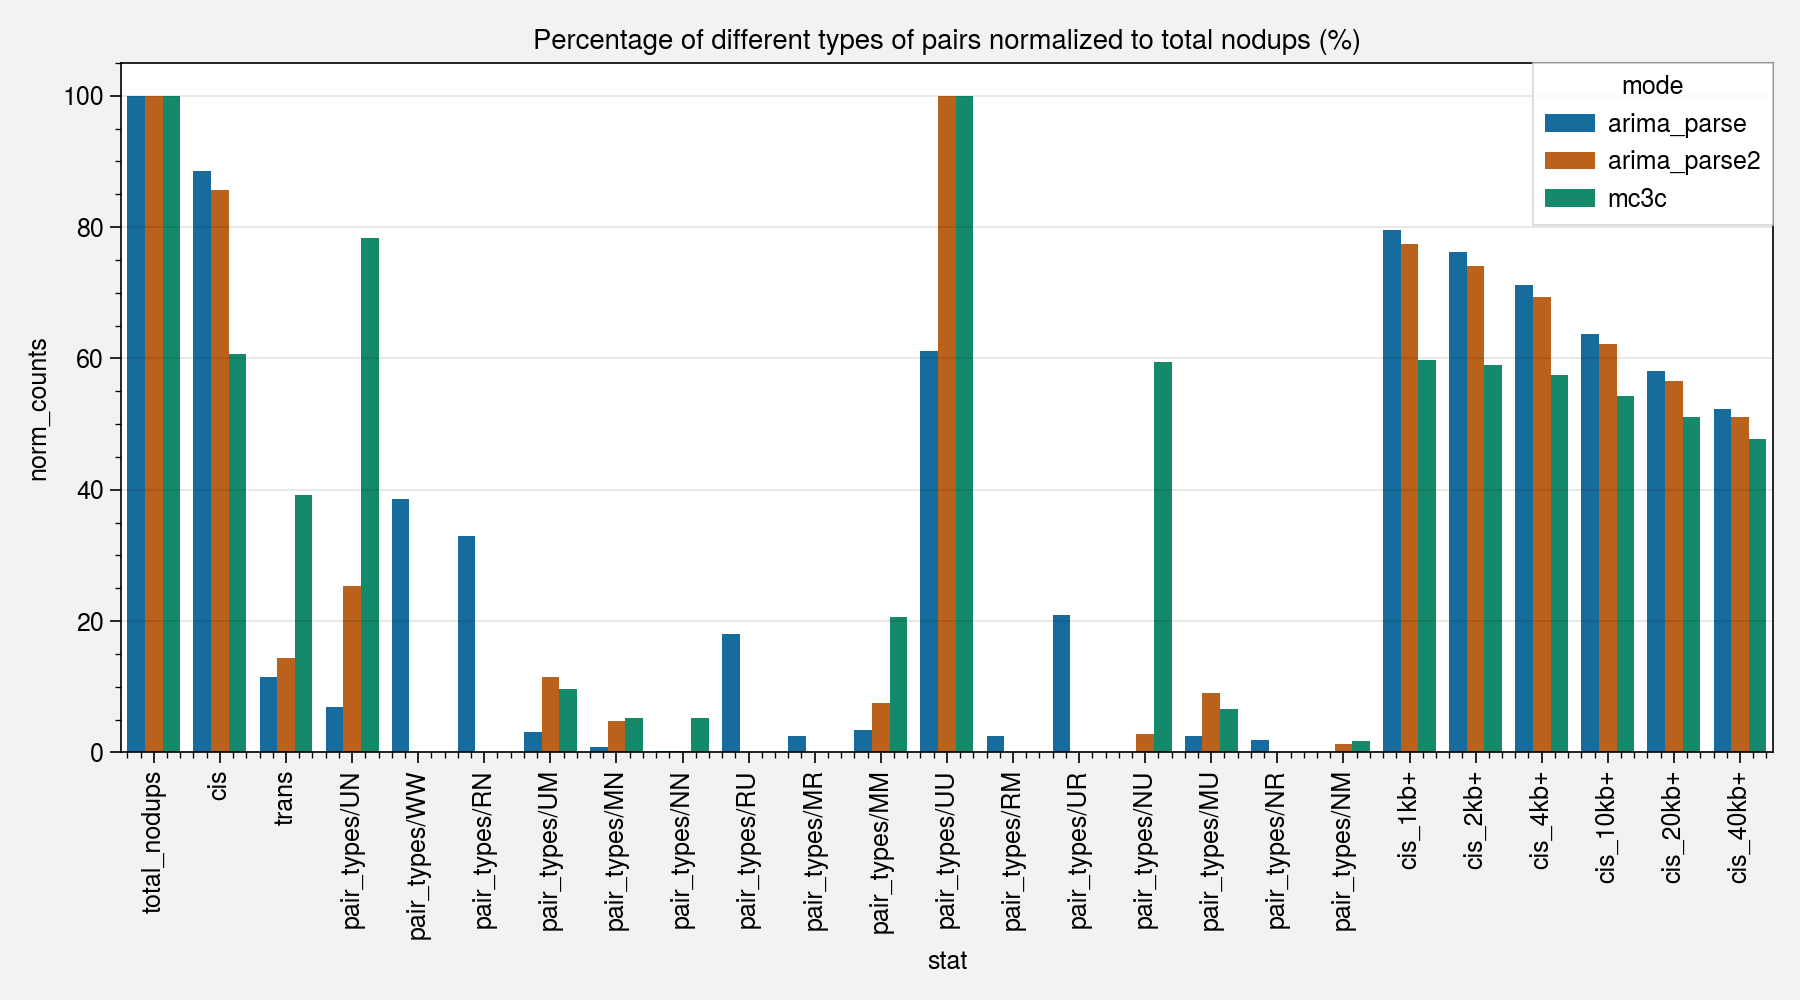

In [192]:
columns = [x for x in stats_parse.index if not 'freq' in x][5:]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='norm_counts', x='stat', hue='mode')
plt.xticks(rotation=90)
plt.title('Percentage of different types of pairs normalized to total nodups (%)')
plt.tight_layout()

# Note increase in trans interactions for MC3C:

Check P(s) for three regimes:

In [177]:
stats_mc3c.loc[:, 'cis_norm_counts'] = 100*stats_mc3c['count']/stats_mc3c.loc['cis', 'count']
stats_parse.loc[:, 'cis_norm_counts'] = 100*stats_parse['count']/stats_parse.loc['cis', 'count']
stats_parse2.loc[:, 'cis_norm_counts'] = 100*stats_parse2['count']/stats_parse2.loc['cis', 'count']

In [179]:
stats_all = pd.concat([stats_parse, stats_parse2, stats_mc3c])

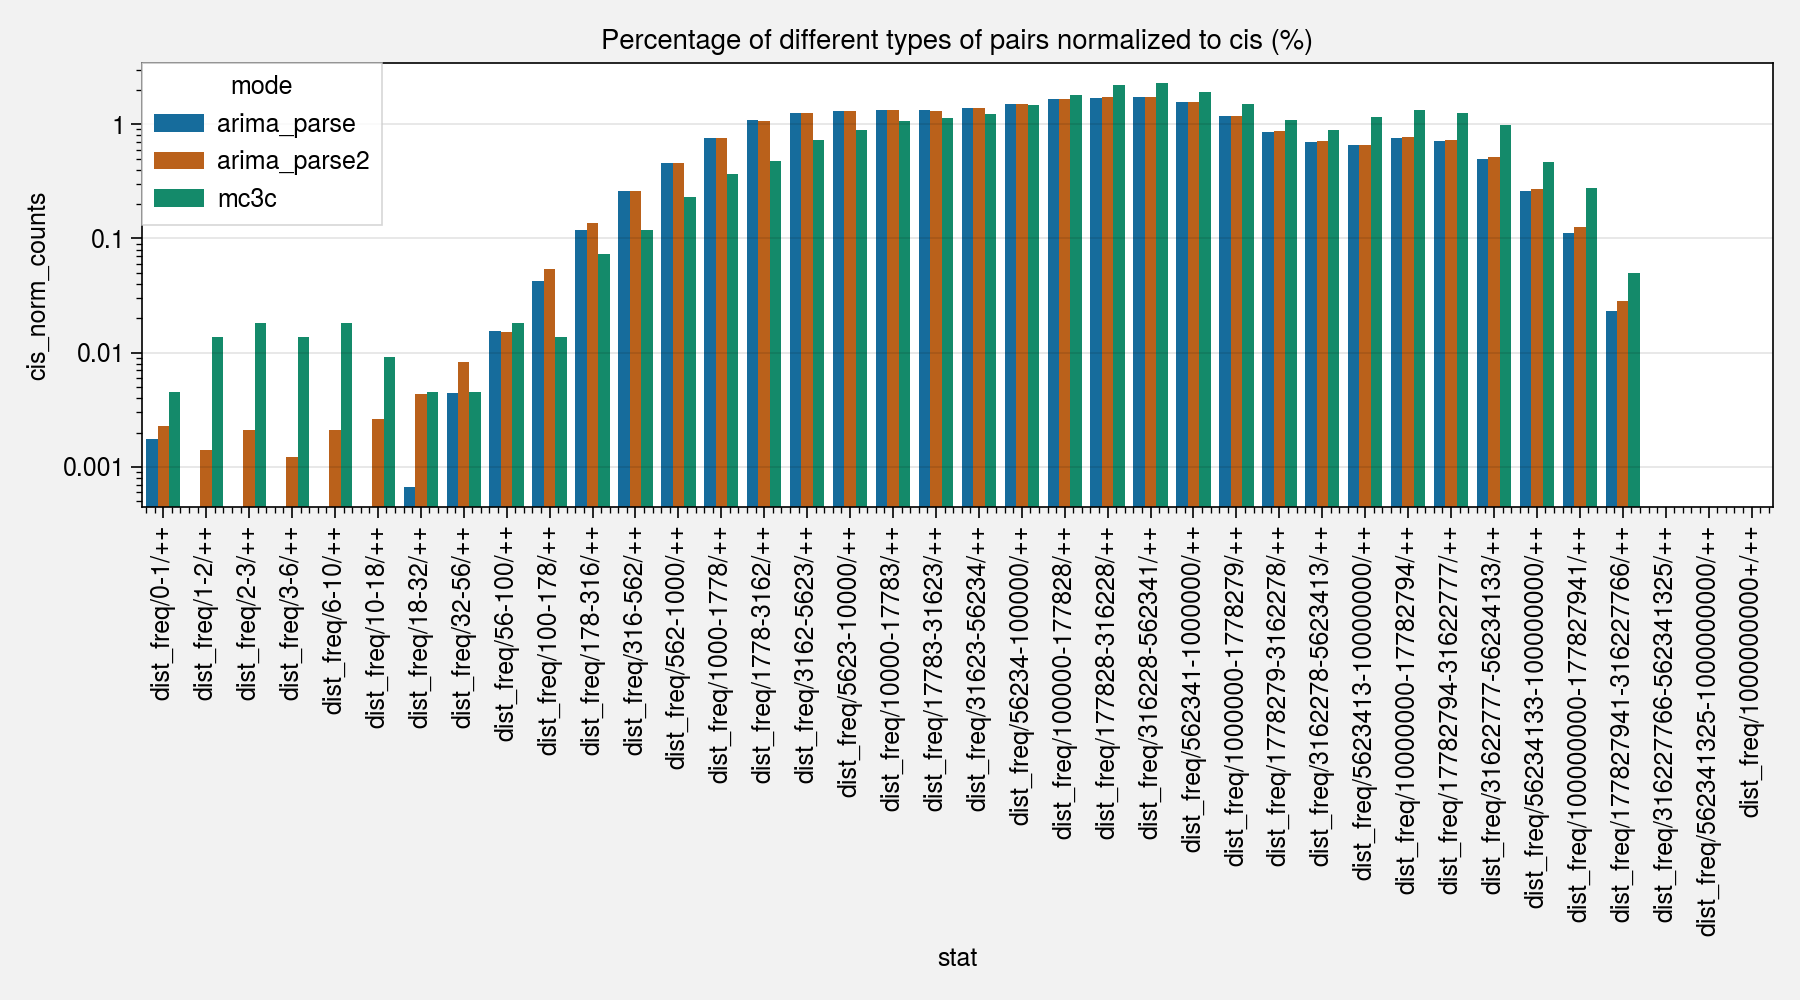

In [186]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '++' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='cis_norm_counts', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Percentage of different types of pairs normalized to cis (%)')
plt.tight_layout()

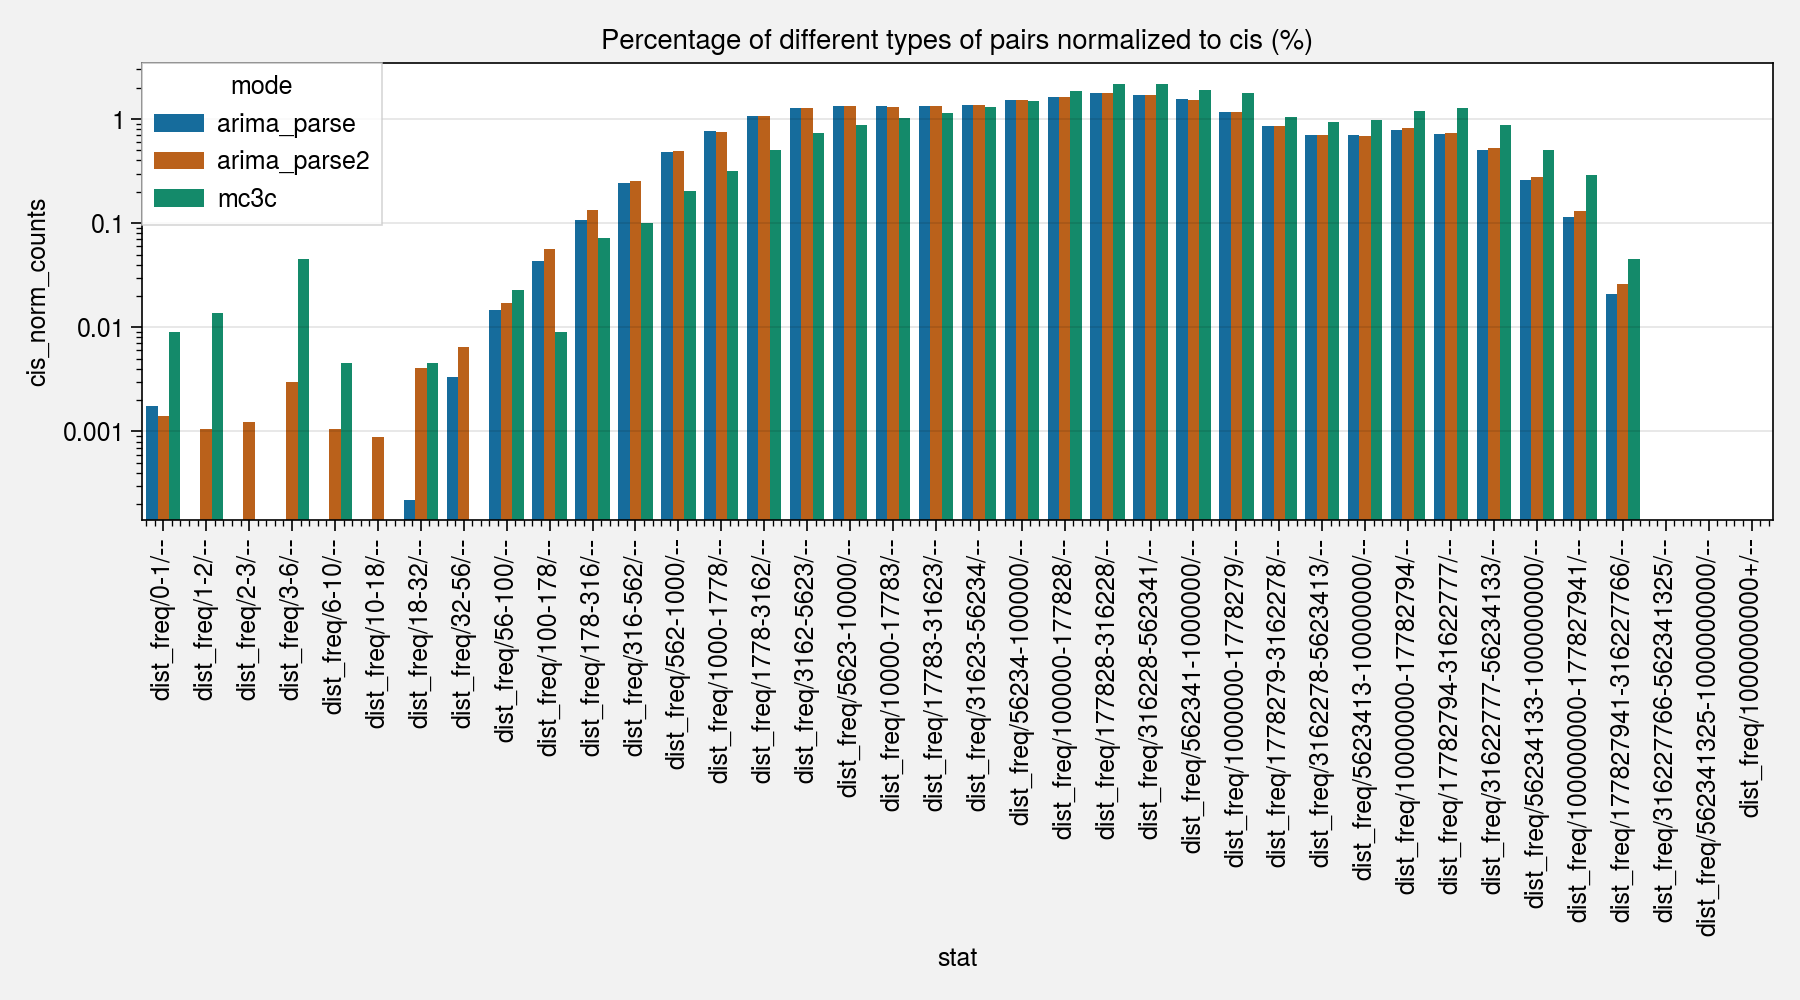

In [187]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '--' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='cis_norm_counts', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Percentage of different types of pairs normalized to cis (%)')
plt.tight_layout()

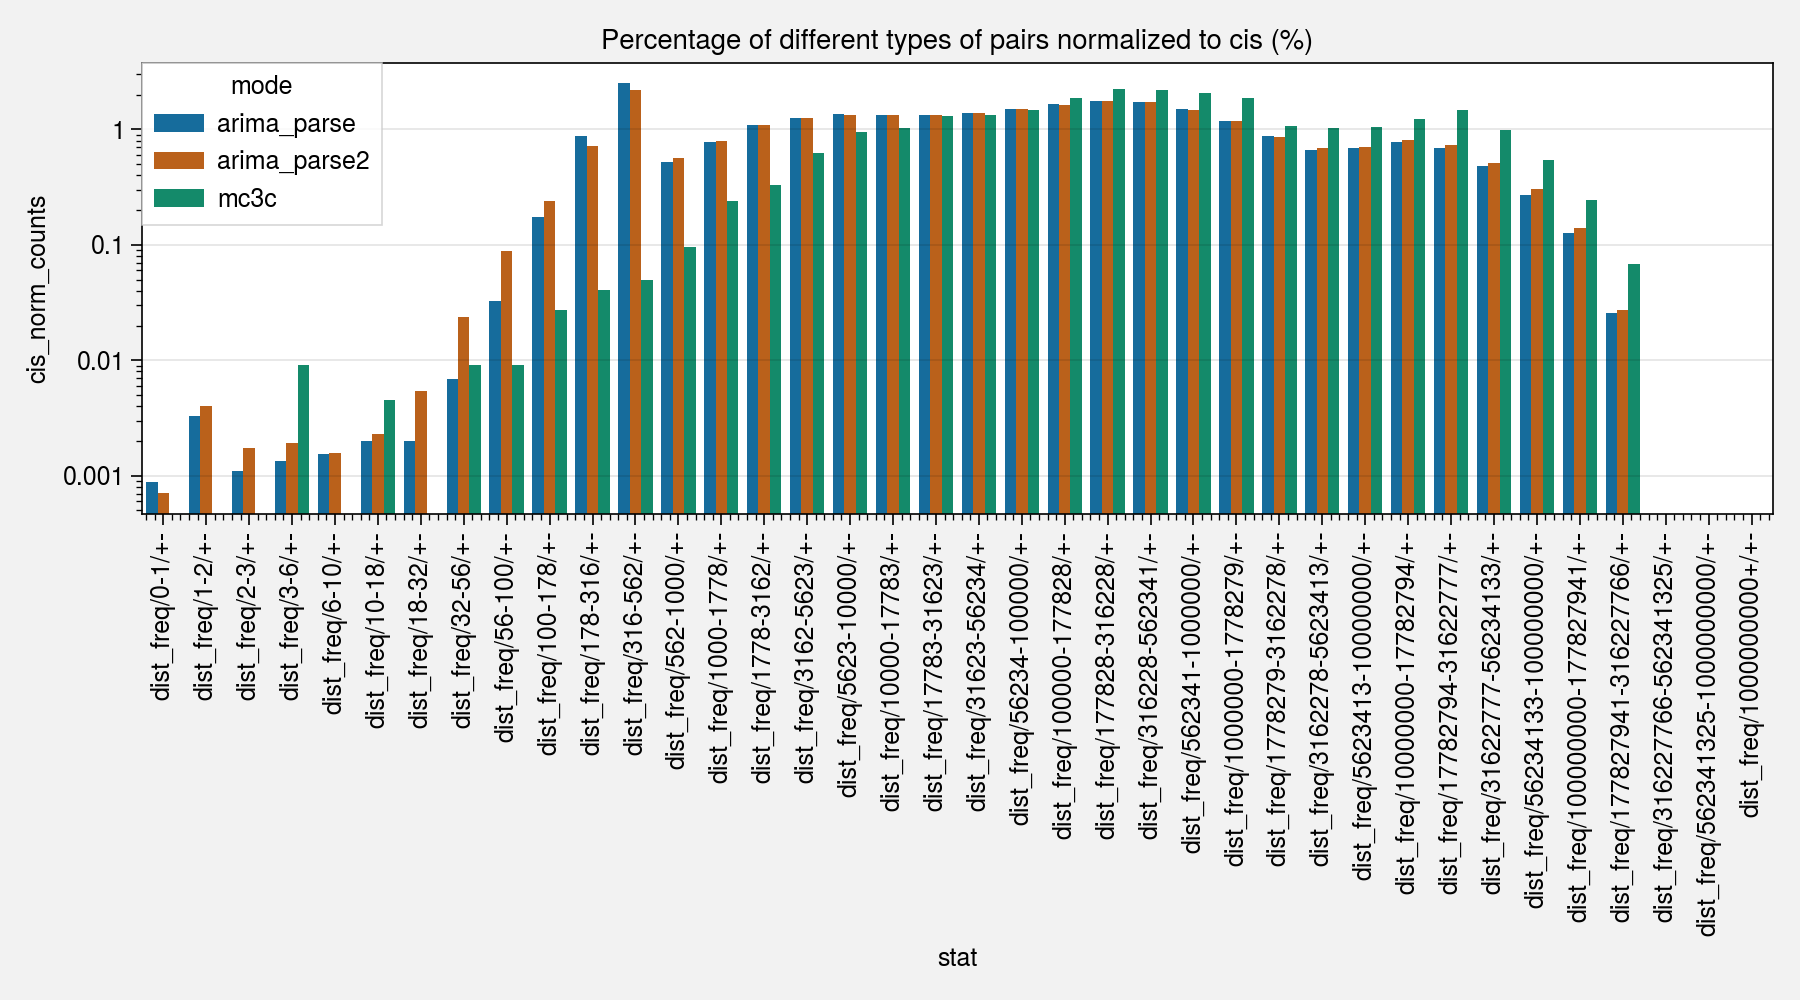

In [188]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '+-' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='cis_norm_counts', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Percentage of different types of pairs normalized to cis (%)')
plt.tight_layout()

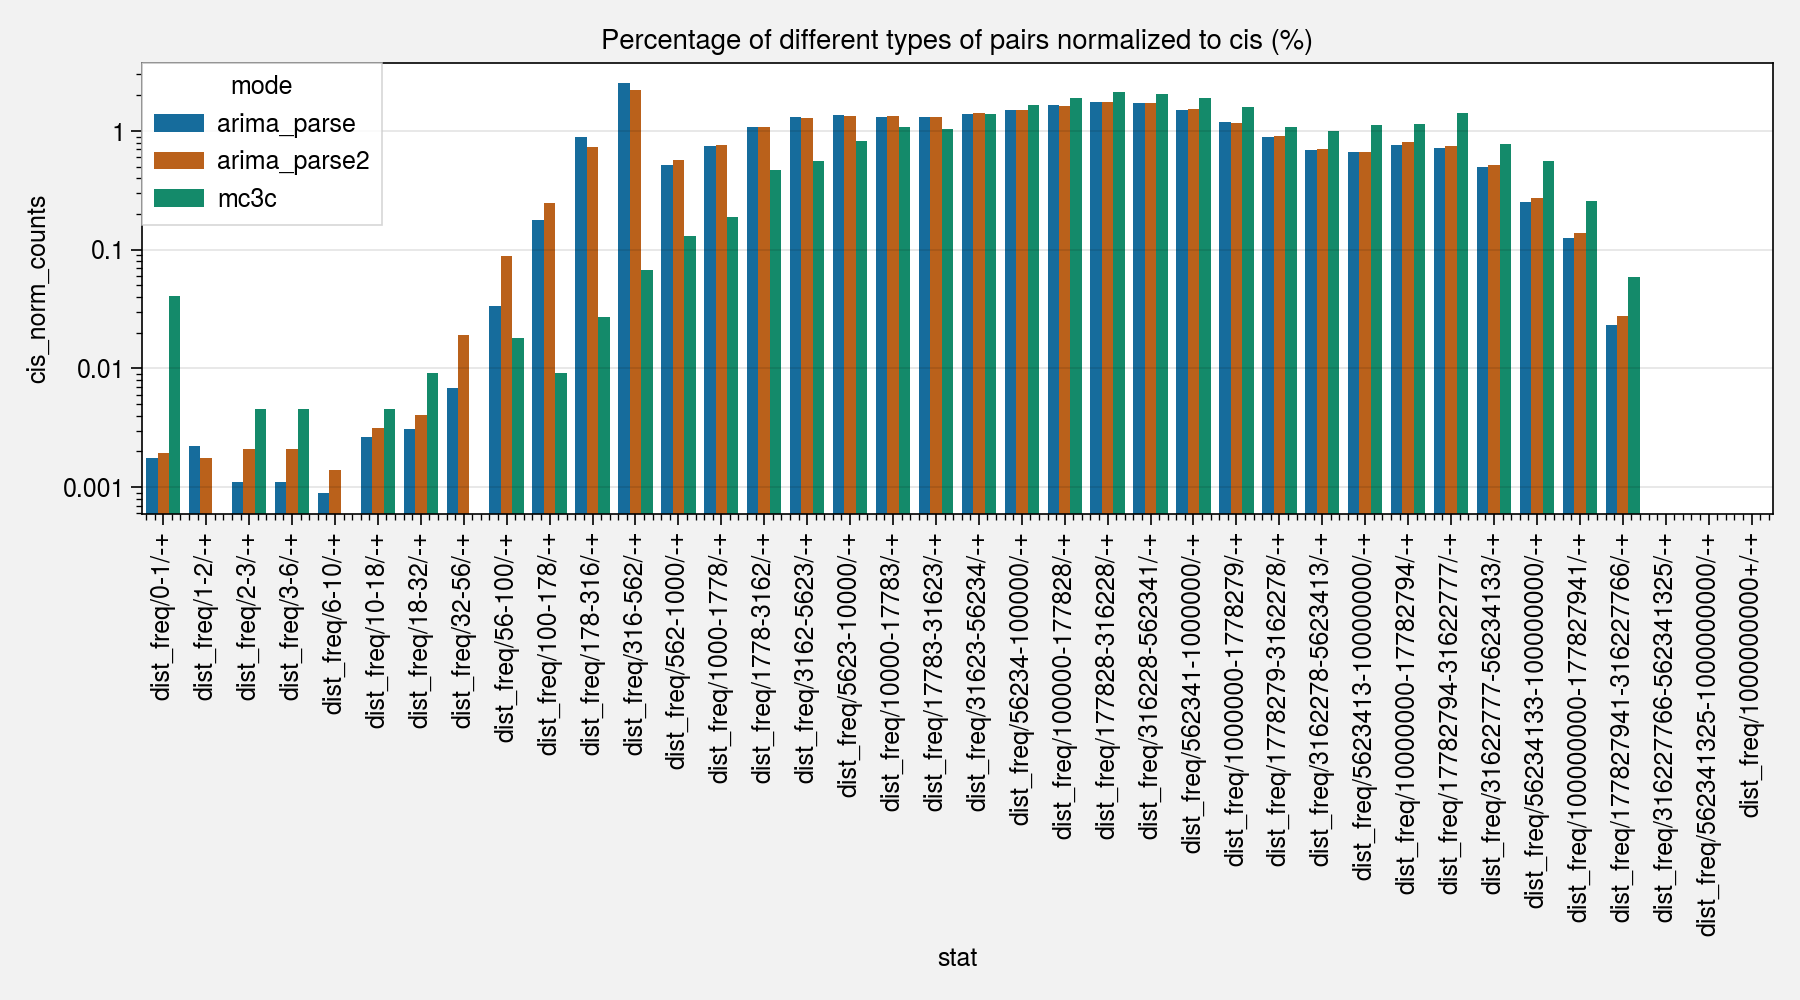

In [189]:
columns = [x for x in stats_parse.index if 'dist_freq' in x and '-+' in x]

plt.figure(figsize=[9, 5])

sns.barplot(data=stats_all.loc[columns, :].reset_index(), y='cis_norm_counts', x='stat', hue='mode')

plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Percentage of different types of pairs normalized to cis (%)')
plt.tight_layout()

## ~~Single-cell example~~

~~snHi-C dat on K562 from Ilya Flyamer:~~

To be implemented

In [8]:
# Download test data
! fastq-dump SRR3344037 --minSpotId 0 --maxSpotId 1000000

Read 1000000 spots for SRR3344037
Written 1000000 spots for SRR3344037
